<center><h1>Creating a New UMD Dining Hall Nutrition Database and Classifying Vegetarian Dishes</h1><h4>Brooke Rice, Mitchell Smith</h4></center><hr>

The University of Maryland (UMD) dining halls are famous with students for their occasionally questionable array of sustenance. Trying to find nutrition information for any given meal is also notoriously difficult due to the horrendously arranged online campus dining database. That's why we're going to do a walkthough of creating a new, accesible dining hall nutrition database and show how this data can be used to train an is-vegetarian food classifier. This will be an end-to-end tutorial covering all steps from data acquisition to generalization error estimation. Our key learning objectives are thus as follows...
1. [(web scraping)](#scraping) get necessary nutrition facts from the UMD dining halls website
2. [(data tidying)](#data_tidying) prepare scraped data for interpretation
3. [(data visualization)](#database) create a read-only web database for easily querying nutrition information
4. [(exploratory data analysis)](#eda) checking sodium and sugar contents and comparing with health guidelines
5. [(machine learning)](#ml) train a "contains meat" classifier for seeing whether a given dish contains meat using only UMD dining hall data
6. [(data analysis)](#validation) predict generalization loss and draw conclusions

For the sake of this project, we will be using the [requests library](https://docs.python-requests.org/en/latest/), [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), and [Pandas](https://pandas.pydata.org/docs/) to scrape and store data. We will create a searchable UI using [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/), and machine learning will be performed using [scikit-learn](https://scikit-learn.org/stable/). Nutrition data will be sourced from https://nutrition.umd.edu/, and our generalization estimation set will come from INSERT-OTHER-NUTRITION-DB. We feel this project is relevant in that it is producing a more accessible and directly useful nutrition database while demonstrating the end to end data acquisition to machine learning analysis process.
 
<a id=scraping></a>
# Scraping the UMD dining hall nutrition data
### Section 1: Collecting nutrition links
Before going straight into the scraping code, check out https://nutrition.umd.edu/. After a couple clicks, you might notice that the UMD dining hall web pages attempt to display a dynmaic meal page based off the query date. Since we want our database to function regardless of the current date, we can start our search from the base page for the South Campus Dining Hall (without providing a date). We can then automatically pick up on the current day's meal information by grabbing each meal's current weblink (see [footnote](#footnote) for the case that the website has gone offline or the dining halls are currently closed). 

After taking care of the dynamic date query aspect, we are free to start pulling information about the foods provided for each meal (breakfast, lunch, and dinner). Each individual food item link will lead us to the nutrition facts label that we want, but these label pages do not list whether a dish is vegetarian! Instead, whether or not a food item contains meat is listed on the corresponding meal page alongside the link to an item's nutrition label.

Because of this, we need to manually iterate through the food items table (as opposed to grabbing all relevant links with a single call to find_all()) and record the separate information about whether a dish is vegetarian. We can then able to cycle through each meal to copy all of the unique nutrition label links. Note that we say "unique" because some foods may be served across multiple meals. We'll use a set to avoid duplicate scraping.

In [1]:
# import standard html scraping libraries
from bs4 import BeautifulSoup
import requests

# declare base link (used in most of the site's hyperlinks)
baseSite = 'https://nutrition.umd.edu/'

# request dining hall nutrition webpage from minimized URL
r = requests.get(f'{baseSite}shortmenu.aspx?locationNum=16&naFlag=1')
htmlTree = BeautifulSoup(r.content)

# find links to each of breakfast, lunch, and dinner menu pages
mealLinks = [baseSite + str(link['href']) 
             for link in htmlTree.find_all('a', href=True)
             if 'meal' in str(link)]

# combine meal names with weblinks for clarity
mealNames = ['breakfast', 'lunch', 'dinner']

# note that there is no breakfast on sundays...
mealNames = mealNames[1:] if len(mealLinks) < 3 else mealNames
mealPages = list(zip(mealNames, mealLinks))

# prepare output structure for storing food links
nutritionLinks = []

# note that there is overlap betw meals for some food items, so use a set to avoid duplication
prevWork = set()

# and record food table attributes for ease of access
tableAttributes = {"align":"center", "border":"1", "width":"70%", "cellspacing":"0", 
                   "cellpadding":"0", "bordercolor":"gray", "bgcolor":"#FFFFFF"}

# get nutrition information on a meal by meal query basis
for mealPage in mealPages:
    # print basic information about each meal page
    print(f'{mealPage[0]}: {mealPage[1]}')
    # query each meal page for food item elements
    r = requests.get(mealPage[1])
    htmlTree = BeautifulSoup(r.content)
    # vegetarian information is provided next to nutrition link in table
    table = htmlTree.find_all('table', attrs=tableAttributes)[0]
    tableRows = table.find_all('tr')
    # so loop through all table entries
    foodLinks = []
    for entry in tableRows:
        # and skip those entries which do not contain a food link
        if 'href' not in str(entry) or 'RecNumAndPort' not in str(entry):
            continue
        # then label foodlinks as vegetarian or not
        link = [str(link['href'])
                for link in entry.find_all('a', href=True)
                if 'RecNumAndPort' in str(link)][0]
        link = baseSite + link
        # do not reprocess links
        if link in prevWork:
            continue
        prevWork.add(link)
        if 'vegetarian' in str(entry):
            foodLinks.append([True, link])
        else:
            foodLinks.append([False, link])
    # store links in output dict
    nutritionLinks.extend(foodLinks)

breakfast: https://nutrition.umd.edu/longmenu.aspx?sName=&locationNum=16&locationName=&naFlag=1&WeeksMenus=This+Week%27s+Menus&dtdate=12%2f16%2f2021&mealName=Breakfast
lunch: https://nutrition.umd.edu/longmenu.aspx?sName=&locationNum=16&locationName=&naFlag=1&WeeksMenus=This+Week%27s+Menus&dtdate=12%2f16%2f2021&mealName=Lunch
dinner: https://nutrition.umd.edu/longmenu.aspx?sName=&locationNum=16&locationName=&naFlag=1&WeeksMenus=This+Week%27s+Menus&dtdate=12%2f16%2f2021&mealName=Dinner


<a id="footnote"></a>
NOTE: because the dining halls close over break, it is entirely possible that you will NOT be able to get meal information outside of Fall and Spring semesters! If you would like to continue with this tutorial while the site is down, please download our previously generated database file from [here]() and skip to the [Data tidying](#data_tidying) section. You can then load the uncleaned dataframe prior to continuing by loading the downloaded pickle file as follows...
```python
df = pandas.read_pickle("downloadedFile")
```

### Section 2: collecting nutrition information
To actually get our nutrition data, we need to query each individual food item's nutrition label page. We can start by declaing the nutrition facts we want to grab for our new database, and then we can scrape for each of the desired nutrition label elements on a per-food-item basis. 

The nutrition facts are stored in nested HTML tables using span tags, so with a bit of string parsing we can pull them directly from each food item's span tag set. We do have to grab the food name and serving size separately since they are stored in different tables. We should also keep in mind that there are a handful of food items with no nutrition data (mostly vegan dishes), so we should be careful not to query them for data which doesn't exist.

After rendering each individual nutrition fact, we can append it to the dataframe we declared earlier (loading all of the pre-defined target nutrition facts). Since this is a lengthy process and we have no gaurantee that the dining hall's websites will maintain the same format forever, we should go ahead and save our final dataframe to a pickle file for safe keeping. This will allow us to continue performing analysis and hosting nutrition data even after the dining hall webpages go offline. It's also worth noting that the nutrition data above is for a single serving of the corresponding food item (which might be measured in ounces or in numbers of the food item itself).

In [2]:
# import pandas so that we can create a nutrition dataframe
import pandas as pd

# declare nutrition dataframe and desired information
stats = ['Total Fat', 'Total Carbohydrate.', 'Saturated Fat', 'Dietary Fiber', 'Trans Fat',
        'Total Sugars', 'Cholesterol', 'Sodium', 'Protein', 'Calories', 'Carbohydrates', 
        'Vitamin C', 'Allergens', 'Is Vegetarian', 'Serving Size', 'Food']
df = pd.DataFrame(columns=stats)

# integer for getting unique indices
entryNum = 0

# also create a structure for recording the handful of foods with no nutrition information
missingInfo = {}

# iterate through each meals nutrition links
for vegFlag,link in nutritionLinks:
    # query each food item's nutrition page
    r = requests.get(link)
    htmlTree = BeautifulSoup(r.content)
    # grab title of food item
    title = htmlTree.find('div', {"class":"labelrecipe"}).contents[0]
    # edge case: certain vegan foods do not have nutrition information!
    if (len(htmlTree.findAll('div', {"class":"labelnotavailable"})) != 0):
        missingInfo[title] = link
        continue
    # else, grab serving size 
    servingSize = htmlTree.findAll('div', {"class":"nutfactsservsize"})[1].contents[0]
    # collect allerges
    allergens = htmlTree.findAll('span', {"class":"labelallergensvalue"})[0].contents
    allergens = allergens[0] if len(allergens) > 0 else ""
    # then get misc. nutrition facts from webpage
    rawNutritionFacts = htmlTree.find_all('span', {"class":"nutfactstopnutrient"})
    # format nutrition information
    nutritionFactsList = [['Allergens', allergens], ['Is Vegetarian', vegFlag], \
                          ['Food', str(title)], ['Serving Size', servingSize]]
    for fact in rawNutritionFacts:
        fact = list(filter(lambda str: len(str) != 0, fact.text.split('\xa0')))
        if (len(fact) == 2):
            nutritionFactsList.append(fact)
    nutritionFacts = dict(nutritionFactsList)
    # create new dataframe entry!
    df.loc[entryNum] = nutritionFacts
    # and increment entry num
    entryNum += 1
    
# save dataframe to pickle file!
df.to_pickle('umd_nutrition.pkl')
    
# return resultant dataframe
df

,Total Fat,Total Carbohydrate.,Saturated Fat,Dietary Fiber,Trans Fat,Total Sugars,Cholesterol,Sodium,Protein,Calories,Carbohydrates,Vitamin C,Allergens,Is Vegetarian,Serving Size,Food
0,21.2g,0g,7.6g,0g,0gram,0g,45.4mg,997.9mg,15.1gram,241.9kcal,0gram,0mg,,False,2 ea,Bacon
1,3.8g,15.9g,1.9g,0.4g,0gram,4.2g,9.2mg,284mg,1.9gram,107.5kcal,15.9gram,0mg,"Milk, Eggs, Wheat, Soybeans",True,1 ea,Pancakes Plain
2,22.3g,0g,14.2g,0g,0gram,0g,60.8mg,0mg,0gram,202.5kcal,0gram,0mg,Milk,True,1 oz,Butter
3,0g,15g,0g,0g,0gram,14.4g,0mg,66.4mg,0gram,57.8kcal,15gram,0mg,,True,1 oz,Maple Syrup
4,22.3g,0g,10.1g,0g,0gram,0g,0mg,212.6mg,0gram,202.5kcal,0gram,0mg,Soybeans,True,1 oz,Margarine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,1.3g,121.6g,0.5g,17.2g,0gram,39.5g,0mg,196.6mg,9.5gram,525.2kcal,121.6gram,0mg,,True,1 each,Baked Sweet Potato
336,12.2g,21.4g,0g,3.1g,0gram,0g,0mg,473.1mg,19.8gram,259.4kcal,21.4gram,mg,"Wheat, Soybeans",True,1 each,Breaded Chicken Cutlet
337,1.4g,12.7g,0.1g,2.5g,0gram,0g,0mg,101.2mg,0.8gram,59.8kcal,12.7gram,0mg,,True,3 oz,Lemon Pepper Roasted Yellow Squash
338,3.6g,8.6g,0.9g,0.9g,0gram,0.1g,0mg,148.6mg,0.9gram,70.3kcal,8.6gram,0.9mg,Soybeans,True,4 oz,Tater Tots


<a id='data_tidying'></a>
# Data tidying: cleaning the nutrition data
After some poking around in our dataframe, we notice that there are a handful of nutrition labels which simply drop nutrients that were not part of the corresponding food item (ie: grilled hotdogs do not include an entry for dietary fiber). We likewise need to account for NaN values by replacing them with a 0. We can also convert our string measurements into floats to simplify data analysis. To that end, we should grab our measurement units and store them elsewhere for later reference.

We do NOT explicitly convert serving size because it is not provided with consistent units. By this we mean that most food items have their servings measured in ounces, but others are measured in terms of individual food objects. We also leave the food name and "Is Vegetarian" columns as-is since they are inherently non-numeric.

In [3]:
# import regex for string parsing
import re
# import numpy for boolean typing
import numpy as np

# record units used for nutrition measurements
units = dict(zip(stats, ['grams', 'grams', 'grams', 'grams', 'grams', 'grams', 
                         'milligrams', 'milligrams', 'grams', 'kcal', 'grams', 'milligrams', 
                         'N/A', 'N/A', 'N/A', 'N/A']))

# certain foods have duplicate entries in the database (ie. pork enchiladas), so remove duplicates
df.drop_duplicates(subset=['Food'], inplace=True)

# clean NaNs
toUpdate = {}
# NaNs indicate that the label did not include a nutrient (b/c the food has none, ie. hotdogs and fiber)
for idx,row in df.iterrows():
    numNans = len([entry for entry in row if str(entry).lower() == 'nan'])
    newRow = [entry if str(entry).lower() != 'nan' else "0" for entry in row]
    if numNans != 0:
        toUpdate[idx] = newRow

# so replace NaNs with 0!
for idx,row in toUpdate.items():
    df.loc[idx] = row
        
# define function to convert string measurement to numeric
def convertToNumeric(string):
    try:
        # when re-running code, do not erase pre-converted values!
        return float(re.sub(r'[a-zA-Z]', '', string)) if type(string) == type("") else string
    except:
        # some labels drop missing nutrients
        return float(0)

# then update columns to reflect their numeric counterparts
for colName in df.columns:
    # do not convert inherently non-numeric columns!
    if (colName == "Food" or colName == "Serving Size" \
        or colName == "Is Vegetarian" or colName == "Allergens"):
        newCol = df[colName]
    else: 
        newCol = [convertToNumeric(measurement) for measurement in df[colName]]
    # explicitly drop and re-add column in order to avoid issues with shallow copying
    df = df.drop(columns=[colName])
    df[colName] = newCol

# return updated dataframe
df

,Total Fat,Total Carbohydrate.,Saturated Fat,Dietary Fiber,Trans Fat,Total Sugars,Cholesterol,Sodium,Protein,Calories,Carbohydrates,Vitamin C,Allergens,Is Vegetarian,Serving Size,Food
0,21.2,0.0,7.6,0.0,0.0,0.0,45.4,997.9,15.1,241.9,0.0,0.0,,False,2 ea,Bacon
1,3.8,15.9,1.9,0.4,0.0,4.2,9.2,284.0,1.9,107.5,15.9,0.0,"Milk, Eggs, Wheat, Soybeans",True,1 ea,Pancakes Plain
2,22.3,0.0,14.2,0.0,0.0,0.0,60.8,0.0,0.0,202.5,0.0,0.0,Milk,True,1 oz,Butter
3,0.0,15.0,0.0,0.0,0.0,14.4,0.0,66.4,0.0,57.8,15.0,0.0,,True,1 oz,Maple Syrup
4,22.3,0.0,10.1,0.0,0.0,0.0,0.0,212.6,0.0,202.5,0.0,0.0,Soybeans,True,1 oz,Margarine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,1.3,121.6,0.5,17.2,0.0,39.5,0.0,196.6,9.5,525.2,121.6,0.0,,True,1 each,Baked Sweet Potato
336,12.2,21.4,0.0,3.1,0.0,0.0,0.0,473.1,19.8,259.4,21.4,0.0,"Wheat, Soybeans",True,1 each,Breaded Chicken Cutlet
337,1.4,12.7,0.1,2.5,0.0,0.0,0.0,101.2,0.8,59.8,12.7,0.0,,True,3 oz,Lemon Pepper Roasted Yellow Squash
338,3.6,8.6,0.9,0.9,0.0,0.1,0.0,148.6,0.9,70.3,8.6,0.9,Soybeans,True,4 oz,Tater Tots


Note that we have chosen to use a Pandas dataframe for data storage. We reccommend using Pandas for these tasks because:
1. Pandas makes tabular data representation incredibly easy (fast queries, updates, column additions, reindexing, filtering, basic statistics...)
2. Pandas has incredible support across the industry (as the de facto standard for tabular data, can automatically interface with HTML sources, output to SQL, interface with numpy and scipy, scikit-learn and statsmodels integrations, etc)

<a id="database"></a>
# Data visualization: creating a read-only web database
At this point in the process, we have already acquired and cleaned the desired nutrition data. With the backing dataset more or less complete, creating a database becomes trivial. For our purposes, we only want the ability to read nutrition data. Only UMD dining hall workers should be able to create, update, or delete menu items. That said, to create a read-only interface for our nutrition data, we would typically recommend [bamboolib](https://bamboolib.8080labs.com/). It's the perfect tool for this sort of thing, yet we will be creating our own interface with [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) for ease of HTML hosting.

Libraries aside, we want our new nutrition database to function just like UMD's- we should be able to query for whatever food we desire (by name) and get a quick nutrition facts sheet with allergens listed. To that end, we will need to define a simple string search for finding close food matches (ie. "fwench" should find "French Toast") as well as a label generation method (for outputting nutrition information). We then want our interface to make use of these functions for a searchable nutrition dataset.

In [4]:
# import widgets library
import ipywidgets as widgets
from IPython.display import display, clear_output
# import difflib for finding close string matches
import difflib

### QUERY LOGIC ###
# create a simple search function (returns indices of similarly named foods)
def searchDataframe(foodName):
    indices = []
    # try getting close matches with difflib
    possibleMatches = difflib.get_close_matches(foodName, df['Food'].str.lower())
    # if unsuccessful, manually search for food name in food set
    if len(possibleMatches) == 0:
        # look for decreasingly small substrings of input name in dataset
        for i in range(0,len(foodName)):
            currSubString = foodName[i:len(foodName)].lower()
            possibleMatches = [food for food in df['Food'].str.lower()
                               if currSubString in food]
            # break when a match is found
            if len(possibleMatches) != 0:
                break
            # try it in reverse as well
            currSubString = foodName[0:len(foodName) - i].lower()
            possibleMatches = [food for food in df['Food'].str.lower()
                               if currSubString in food]
            # break when a match is found
            if len(possibleMatches) != 0:
                break
    # then return the indices of possible matches (or an empty list if no match found)
    return [df.index[df.Food.str.lower() == m] for m in possibleMatches]
    
### LABEL GENERATION / PRETTY PRINT ###
# pretty print method for creating nutrition labels from a dataframe index
def getLabel(index):
    # get the corresponding row
    row = df.loc[index]
    # change index to the food name, and drop the food name entry
    row.index = row["Food"]
    row = row.drop(columns=["Food"])
    # then format each nutrition measurement with proper units
    label = pd.DataFrame()
    for nutrient in row.columns:
        # do not reformat serving size or allergens strings!
        if nutrient == "Serving Size" or nutrient == "Allergens":
            label[nutrient] = row[nutrient][0]
        # do convert vegetarian flag -> yes or no
        elif nutrient == "Is Vegetarian":
            label[nutrient] = "Yes" if row[nutrient][0] else "No"
        # and do add units to numeric data
        else:
            label[nutrient] = pd.Series(f"{str(row[nutrient][0])} {str(units[nutrient])}")
    # set the food name and return!
    label.index = row.index
    return label
    
### USER INTERFACE ###
# create a search button
searchButton = widgets.Button(description="search")

# create a simple textbox for querying for food items
strIn = widgets.Text(
    placeholder='search for foods',
    disabled=False
)

# group search button + text input
searchWidg = widgets.Box([strIn, searchButton])
display(searchWidg)

# create a text output region for returning query results
strOut = widgets.Text(
    placeholder='(query results)',
    disabled=False
)
    
# define click event for searching
output = widgets.Output()
@output.capture()
def on_button_clicked(init):
    # clear previous output, find possible food matches
    clear_output()
    possibleMatchIndices = searchDataframe(strIn.value)
    # pretty print nutrition labels for each
    for index in possibleMatchIndices:
        display(getLabel(index).T)
            
# link search button to click event
searchButton.on_click(on_button_clicked)
display(output)

Box(children=(Text(value='', placeholder='search for foods'), Button(description='search', style=ButtonStyle()…

Output()

We would argue that the above search box is far more convenient than looking for any given food item's nutrition information on https://nutrition.umd.edu/. That said, we realize that a search box alone is not a full-fledged database. For the sake of this tutorial we will briefly demonstrate the creation of a proper SQL database using the previously recorded nutrition information.
## Aside: Creating a true CRUD database
A true database should implement Create, Read, Update, and Delete behavior (the CRUD standard). Since we chose to represent our data using a dataframe, we can make use of Pandas "to_sql()" method in order to create a Structured Query Language (SQL) database from our nutrition records. SQL is a standard language for working with relational databases which has many popular offshoots like SQLite and PostgreSQL, but we won't be diving too deep for the sake of this demonstration. Please refer to Usman Malik's [tutorial](https://realpython.com/python-sql-libraries/) if you would like to learn more about working with SQL in python. A simple example of creating a database and querying for cheeseburgers can be found below: 

In [5]:
# import sqlite libs for easy sql processing in python
import sqlite3

# create a new database for nutrition data
conn = sqlite3.connect('nutrition_database')
c = conn.cursor()

# then load our nutrition data into a new table named "facts"
df.to_sql('facts', conn, if_exists='replace', index = False)

# and issue a test query for burgers
c.execute('''  
            SELECT * FROM facts
            WHERE Food LIKE '%Burger%'
          ''')

# print results!
for row in c.fetchall():
    print(row)

(18.2, 0.0, 7.1, 0.0, 0.8, 0.0, 63.4, 467.7, 15.1, 222.8, 0.0, 0.0, '', 0, '1 each', 'Beef Burger')
(22.8, 0.5, 9.7, 0.0, 0.8, 0.0, 73.6, 445.9, 18.1, 278.5, 0.5, 0.0, 'Milk, Soybeans', 0, '1 each', 'Cheeseburger with American Cheese')
(1.9, 26.8, 0.4, 1.5, 0.0, 2.2, 0.0, 245.8, 4.5, 134.1, 26.8, 0.0, 'Wheat, Soybeans', 1, '1 each', 'Potato Hamburger Roll')
(7.2, 24.2, 0.9, 0.0, 0.0, 3.6, 0.0, 727.2, 10.8, 197.5, 24.2, 0.0, 'Wheat', 1, '1 each', '3 Grain Corn Black Bean Burger')


/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


<a id="eda"></a>
# Exploratory data analysis: too much sugar and sodium?

The FDA's dietary guidelines recmomend consuming no more than [2,300 mg of sodium](https://www.fda.gov/food/food-additives-petitions/sodium-reduction) a day. For men with a 2,000 calorie diet, the American Heart Association recommends no more than [36 grams of sugar](https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.109.192627) per day. That being said, the UMD dining halls have to produce food en masse for the student body. With more than [30,000](https://research.umd.edu/about/facts-figures) undergraduate students, the University has to order frozen foods in bulk in order to feed the student body. These mass-produced foods are notorious for high sodium and sugar contents, so let's how the worst stack up to daily reccomendations...

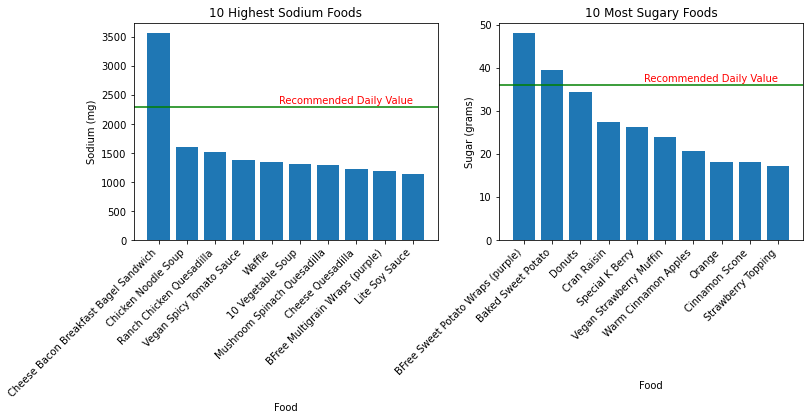

In [148]:
# Get plotting libs
import matplotlib.pyplot as plt

# Grab the 10 highest sodium-content and sugar-content foods
mostSodium = df.nlargest(10, ['Sodium'])
mostSugar = df.nlargest(10, ['Total Sugars'])

# Declare intake limit vars
recSodiumPerDay = 2300
recSugarPerDay = 36

# Prepare output plot panel
fig = plt.figure(figsize=(12, 4))

# Create sodium bar graph
ax = fig.add_subplot(1, 2, 1)
ax.bar(mostSodium["Food"], mostSodium["Sodium"])
ax.title.set_text('10 Highest Sodium Foods')
ax.set_ylabel('Sodium (mg)')
ax.set_xlabel('Food')

# Add expected sodium daily value line, adjust labels
ax.text(9, 2400, "Recommended Daily Value", color="red", ha='right', va='center')
plt.axhline(y = 2300, color = 'green')
plt.xticks(rotation=45, ha='right')

# Create sugar bar graph
ax = fig.add_subplot(1, 2, 2)
ax.bar(mostSugar["Food"], mostSugar["Total Sugars"])
ax.title.set_text('10 Most Sugary Foods')
ax.set_ylabel('Sugar (grams)')
ax.set_xlabel('Food')

# Add expected sugar daily value line, adjust labels
ax.text(8, 37.5, "Recommended Daily Value", color="red", ha='right', va='center')
plt.axhline(y = 36, color = 'green')
plt.xticks(rotation=45, ha='right')
plt.show()

As shown in the above graph, it is possible to exceed the reccomended daily amount of sodium and sugar intake with just two servings of dining hall food! Mixing and matching two of any of the 10 saltiest foods would put a student over the daily limit, yet two servings of the chicken noodle soup wouldn't even add up to 400 calories (leaving students to fill in the rest of their 2,000 calorie a day diet with an ideally negative portion of sodium). Sugar appears to be equally difficult to work around, but we haven't delved into the greater dataset quite yet. With strong evidence to support that there may be far too much sugar and sodium in the average dining hall dish, let's see how the entire database stacks up against reccomended daily values... 

In [ ]:
fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(4,2, 1)
avg_sodium = df['Sodium'].mean()
ax.bar(df['Sodium'] - avg_sodium , (df['Sodium']/2300)*100)
ax.title.set_text('Sodium')
ax.set_xlabel('mg Above or Below Average')
ax.set_ylabel('Percent Daily Value')
    
ax = fig.add_subplot(4,2, 2)
avg_protein = df['Protein'].mean()
ax.bar(df['Protein'] - avg_protein , (df['Protein']/50)*100)
ax.title.set_text('Protein')
ax.set_xlabel('g Above or Below Average')
ax.set_ylabel('Percent Daily Value')

ax = fig.add_subplot(4,2, 3)
avg_sat_fat = df['Saturated Fat'].mean()
ax.bar(df['Saturated Fat'] - avg_sat_fat , (df['Saturated Fat']/20)*100)
ax.title.set_text('Saturated Fat')
ax.set_xlabel('g Above or Below Average')
ax.set_ylabel('Percent Daily Value')

ax = fig.add_subplot(4,2, 4)
avg_total_fat = df['Total Fat'].mean()
ax.bar(df['Total Fat'] - avg_total_fat , (df['Total Fat']/78)*100)
ax.title.set_text('Total Fat')
ax.set_xlabel('g Above or Below Average')
ax.set_ylabel('Percent Daily Value') 

ax = fig.add_subplot(4,2, 5)
avg_cholesterol = df['Cholesterol'].mean()
ax.bar(df['Cholesterol'] - avg_cholesterol , (df['Cholesterol']/300)*100)
ax.title.set_text('Cholesterol')
ax.set_xlabel('mg Above or Below Average')
ax.set_ylabel('Percent Daily Value')

ax = fig.add_subplot(4,2, 6)
avg_carbohydrates = df['Carbohydrates'].mean()
ax.bar(df['Carbohydrates'] - avg_carbohydrates , (df['Carbohydrates']/275)*100)
ax.title.set_text('Carbohydrates')
ax.set_xlabel('g Above or Below Average')
ax.set_ylabel('Percent Daily Value')

ax = fig.add_subplot(4,2, 7)
avg_vitamin_c = df['Vitamin C'].mean()
ax.bar(df['Vitamin C'] - avg_vitamin_c , (df['Vitamin C']/90)*100)
ax.title.set_text('Vitamin C')
ax.set_xlabel('mg Above or Below Average')
ax.set_ylabel('Percent Daily Value')

ax = fig.add_subplot(4,2, 8)
avg_dietary_fiber = df['Dietary Fiber'].mean()
ax.bar(df['Dietary Fiber'] - avg_dietary_fiber , (df['Dietary Fiber']/28)*100)
ax.title.set_text('Dietary Fiber')
ax.set_xlabel('g Above or Below Average')
ax.set_ylabel('Percent Daily Value')

plt.subplots_adjust(hspace = .5)

<a id="ml"></a>
# Preparing a "Contains Meat" Classifier

TODO:
- explain how the model works + why we don't use every feature
- elaborate on present training loss
- integrate 10-fold cv

In [7]:
list_of_features = ['Total Fat', 'Total Carbohydrate.', 'Saturated Fat', 'Dietary Fiber', 'Trans Fat',
        'Total Sugars', 'Cholesterol', 'Sodium', 'Protein', 'Calories', 'Carbohydrates', 
        'Vitamin C']

for feature in list_of_features:
    corrcoef = np.corrcoef(df['Is Vegetarian'].astype(bool), df[feature])[0][1]
    if abs(corrcoef) > .15:
        print(feature)
        print(corrcoef)

Total Fat
-0.22739591182135988
Saturated Fat
-0.1865726465657424
Cholesterol
-0.1524936037822215
Sodium
-0.3144505504834163
Protein
-0.39307486824905785
Calories
-0.15880616066574335


In [8]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import discriminant_analysis
tree_X = df.loc[ : , ['Total Fat','Sodium','Protein', 'Calories','Cholesterol']]
tree_y = df['Is Vegetarian'].astype(bool)
tree_X_train, tree_X_test, tree_y_train, tree_y_test = train_test_split(tree_X, tree_y, test_size=.75)
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(tree_X_train, tree_y_train)
print(tree_model)
tree_expected_y  = tree_y_test

# Running prediction
tree_predicted_y = tree_model.predict(tree_X_test)

# Printing classification output to view strength of model, all looks good
print(metrics.classification_report(tree_expected_y, tree_predicted_y))
print(metrics.confusion_matrix(tree_expected_y, tree_predicted_y))

DecisionTreeClassifier()
              precision    recall  f1-score   support

       False       0.67      0.46      0.55        39
        True       0.91      0.96      0.93       214

    accuracy                           0.88       253
   macro avg       0.79      0.71      0.74       253
weighted avg       0.87      0.88      0.87       253

[[ 18  21]
 [  9 205]]


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = df.loc[ : , ['Total Fat', 'Sodium','Protein','Calories','Cholesterol']]
y = df['Is Vegetarian'].astype(bool)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf=RandomForestClassifier(n_estimators=1000, random_state = 10)
rforestScores = cross_val_score(clf, X, y, cv=10)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(rforestScores)
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

[0.85294118 0.91176471 0.88235294 0.94117647 0.91176471 0.91176471
 0.91176471 0.96969697 0.93939394 0.93939394]
Accuracy:  0.9313725490196079


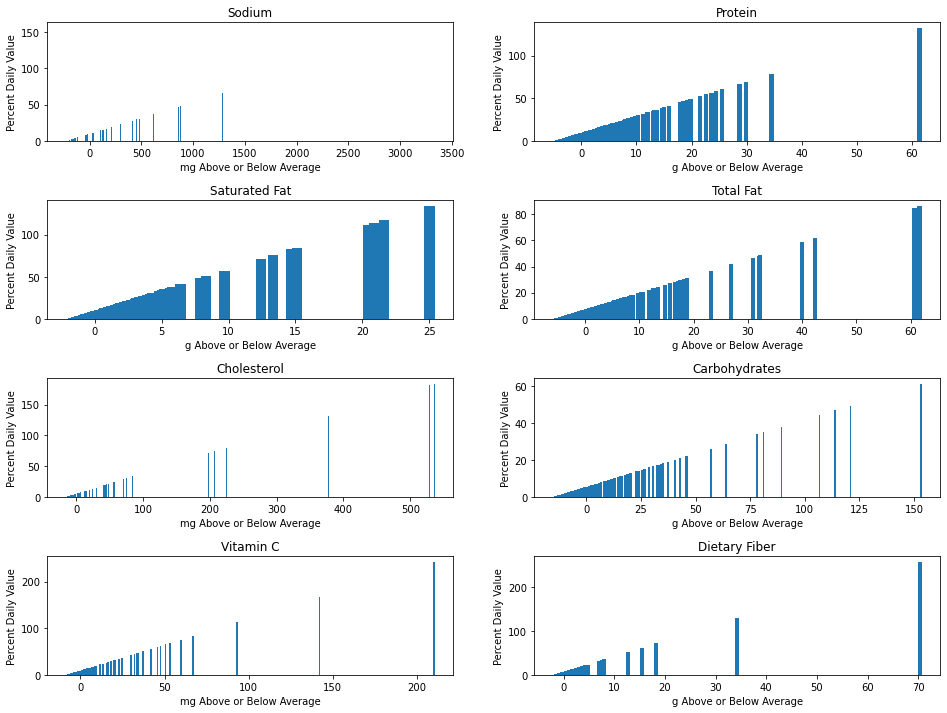

In [11]:
data = pd.read_csv("nutrients_csvfile.csv", sep=',')
data.head()

# Some nutrients are trace amounts labeled as t, replacing to be 0
data.replace(to_replace = 't', value = 0, inplace = True)
data.replace(to_replace = "t'", value = 0, inplace = True)
data.rename(columns = {'Fiber' : 'Dietary Fiber','Carbs' : 'Carbohydrates', 'Sat.Fat' : 'Saturated Fat', 'Fat' : 'Total Fat'}, inplace = True)
# Food at index 91 has a range of calories, changing it to be median of range
data.loc[91, 'Calories'] = (8+44)/2
# Removing commas so that Calories can be read as floats
data['Calories'] = data.Calories.str.replace(',?' , '')
X_test = data.loc[ : , ['Total Fat','Protein','Calories', 'Saturated Fat', 'Carbohydrates']]
X_test.dropna(inplace = True)
data

FileNotFoundError: [Errno 2] No such file or directory: 'nutrients_csvfile.csv'

In [ ]:
from sklearn.model_selection import cross_val_score

X = df.loc[ : , ['Total Fat','Protein','Calories', 'Saturated Fat', 'Carbohydrates']]
y = df['Is Vegetarian'].astype(bool)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1)
clf=RandomForestClassifier(n_estimators=1000, random_state = 10)
rforestScores = cross_val_score(clf, X, y, cv=10)
print(rforestScores)
clf.fit(X,y)
y_pred=clf.predict(X_test)
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
X_test['Is Vegetarian'] = y_pred
merged = data.merge(X_test)
merged.dropna(inplace = True)
merged.drop_duplicates(inplace = True)
merged[merged['Is Vegetarian'] == False]